## Using BERT to Classify text 



In [ ]:
import os
import random
import datetime
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vectors, build_vocab_from_iterator


USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    DEVICE = torch.device('cuda')
    print("Using cuda.")
else:
    DEVICE = torch.device('cpu')
    print("Using cpu.")

seed = 30255    
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if USE_CUDA:
    torch.cuda.manual_seed(seed)

COLAB = True

if COLAB:
    from google.colab import drive 
    drive.mount('/content/gdrive')
    PATH = "gdrive/Shareddrives/Adv ML Project/Data/"
else:
    # Change path to appropriate location
    PATH = "/Users/kilaf/OneDrive - The University of Chicago/CAPP255/Project"
    

Using cuda.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Step 1: Load in pre-processed data and split into train, validation and test datasets using seed 30255

In [ ]:
df = pd.read_csv(os.path.join(PATH + "preprocessed_data.csv"))

In [ ]:
len(df)

6115

Converting the classes we want to classify to integers

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(df['CLASS'])

print(len(labels))

6115


Using the BERT_TOKENIZED column to create our dataloader with the intergerized labels

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def tokenize_text(text):
    """
    Truncating the text to 256 for consistency's sake
    """
    return tokenizer.encode_plus(text,
                                  add_special_tokens=True,
                                  max_length=256,
                                  padding='max_length',
                                  return_attention_mask=True,
                                  return_tensors='pt',
                                  truncation=True)

tokenized_text = df['DESCRIPTION'].apply(tokenize_text)

In [ ]:
tokenized_text[1]['input_ids']

tensor([[  101,  5943, 21346,  1523,  4658, 14271,  2015,  1524,  2031,  2042,
          3818,  2004,  1037,  4022,  3684, 10210, 13340,  3508,  5656,  2005,
          3655,  1012,  2174,  1010,  3025,  2470,  2038,  2025, 23087, 10847,
          1996,  6698,  2000,  2029,  4658, 14271,  2015,  2071,  5547,  3923,
          7715,  1012,  1999,  2023,  2817,  2057, 10847,  1996,  4785, 14670,
          1997,  6923, 10813,  1997,  4658, 14271,  2015,  1999,  2662,  3655,
          1012,  2478,  1996,  4633,  2470,  1998, 19939,  2075,  2944,  1010,
          2057, 23599,  1996,  2783,  4785,  1997,  2662,  2012,  1018,  2463,
         13589,  5813,  1012, 13599,  2023, 12504,  2000,  8746,  4633,  3703,
          1999,  2662,  4081,  2019,  3452,  2812, 13827,  1006,  2944, 15718,
          8089,  1007,  1997,  1516,  1014,  1012,  2382,  7737,  2278,  1012,
          6923, 14271,  2632, 28759,  7457,  1997,  1014,  1012,  1015,  1998,
          1014,  1012,  1018,  1999,  2662,  3655,  

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# create DataLoader - need to stack the lists of tensors into one tensor
input_ids = torch.stack([row['input_ids'] for row in tokenized_text])
attention_mask = torch.stack([row['attention_mask'] for row in tokenized_text])

# Concatenating the Embeddings, Attention Mask and Labels
dataset = TensorDataset(input_ids, attention_mask, torch.tensor(labels, dtype=torch.long))

In [ ]:
# compute train/validation/test split sizes
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# split dataset randomly into train/validation/test sets
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# create data loaders for each set
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [ ]:
import torch.nn as nn
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(labels))
device = torch.device('cuda')
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Step 2: Model Training

In [ ]:
def train_model(model, train_data_loader, optimizer):
    model.train()

    for batch in train_data_loader:
        input_ids, attention_mask, labels = batch
        if USE_CUDA:
                input_ids, attention_mask, labels = input_ids.squeeze(1).cuda(), attention_mask.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = torch.nn.functional.cross_entropy(outputs.logits, labels)

        loss.backward()
        optimizer.step()

In [ ]:
def validate(model, data_loader):
    model.eval() # set model to evaluation mode
    
    # initialize performance metrics
    num_correct = 0
    num_samples = 0
    losses = []
    
    # create data loader for validation set
    
    # iterate over batches in validation set
    for batch in data_loader:
        # extract inputs and targets from batch

        input_ids, attention_mask, labels = batch
        if USE_CUDA:
                input_ids, attention_mask, labels = input_ids.squeeze(1).cuda(), attention_mask.cuda(), labels.cuda()

        
        # compute model outputs and loss
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = torch.nn.functional.cross_entropy(outputs.logits, labels)
        
        # update performance metrics
        losses.append(loss.item())
        _, preds = torch.max(outputs.logits, dim=1)
        num_correct += (preds == labels).sum().item()
        num_samples += labels.size(0)
        
    # compute average loss and accuracy
    avg_loss = sum(losses) / len(losses)
    accuracy = num_correct / num_samples
    
    print(f'Validation Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}')
    
    return avg_loss, accuracy

In [ ]:
num_epochs = 5

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()
val_loss = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    # train model on training set
    train_model(model, train_loader, optimizer)
    
    # validate model on validation set
    accuracy, loss = validate(model, val_loader)
    val_loss.append(loss)

Epoch 1/5
Validation Loss: 4.5957 | Accuracy: 0.2879
Epoch 2/5
Validation Loss: 2.1862 | Accuracy: 0.6172
Epoch 3/5
Validation Loss: 1.2307 | Accuracy: 0.7634
Epoch 4/5
Validation Loss: 0.8533 | Accuracy: 0.7797
Epoch 5/5
Validation Loss: 0.7315 | Accuracy: 0.7830


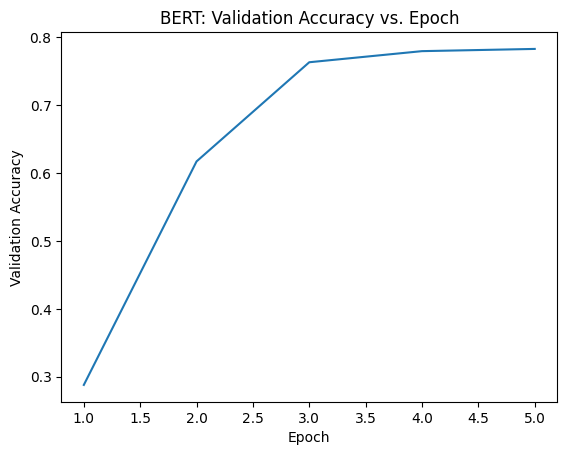

In [ ]:
import matplotlib.pyplot as plt

# plot validation loss
plt.plot(range(1, num_epochs+1), val_loss)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('BERT: Validation Accuracy vs. Epoch')
plt.show()

In [ ]:
accuracy, loss = validate(model, test_loader)

Validation Loss: 0.6419 | Accuracy: 0.8203


In [ ]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# model.to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
# loss_fn = nn.CrossEntropyLoss()


# epochs = 5
# for epoch in range(epochs):
#     train_loss = 0
#     val_loss = 0

#     model.train()
#     optimizer.zero_grad()
#     # Forward pass
#     for batch in train_loader:
#         optimizer.zero_grad()
#         input_ids, attention_mask, labels = batch
#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         train_loss += loss.item()
#         loss.backward()
    
#     # Validation
#     model.eval()
#     with torch.no_grad():
#         val_outputs = model(
#             input_ids=val_texts['input_ids'].to(device),
#             attention_mask=val_texts['attention_mask'].to(device),
#             labels=val_labels.to(device))

#         val_loss = val_outputs.loss
#         val_acc = (val_outputs.logits.argmax(axis=1) == val_labels).float().mean()

#     print(f'Epoch {epoch+1}/{epochs}: Train loss: {loss:.3f}. Val loss: {val_loss:.3f}. Val acc: {val_acc:.3f}')